In [2]:
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.stats import norm
from matplotlib.patches import Rectangle

In [3]:
cog_url = (
    "https://s3.us-east-2.amazonaws.com/vtopendata-prd/Elevation/2017_70cm_DEMHF.tif"
    )
rds = rioxarray.open_rasterio(cog_url, overview_level=4)

In [4]:
rds.squeeze()

<xarray.DataArray (y: 11375, x: 3750)> Size: 171MB
[42656250 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 30kB 4.256e+05 4.256e+05 ... 5.096e+05 5.096e+05
  * y            (y) float64 91kB 2.8e+05 2.8e+05 ... 2.523e+04 2.521e+04
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

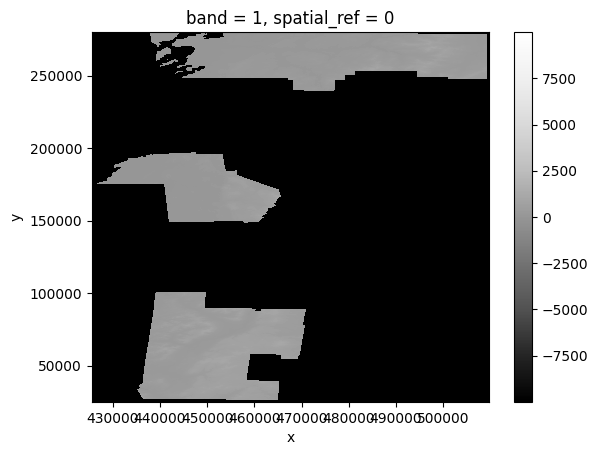

In [5]:
rds.squeeze().plot.imshow(cmap="Greys_r")

In [3]:
def create_cost_map(y_length, x_length, grain_size):
    """
    Creates a spatial map with specified dimensions and grain size.

    Args:
        y_length (float): The length of the map in the y-direction.
        x_length (float): The length of the map in the x-direction.
        grain_size (float): The size of each grid cell.

    Returns:
        pd.DataFrame: A dataframe containing x_coord, y_coord, and cost (all set to 1).
    """
    y_coords = np.arange(0, y_length, grain_size)
    x_coords = np.arange(0, x_length, grain_size)
    data = {'x_coord': [], 'y_coord': [], 'cost': []}

    for x in x_coords:
        for y in y_coords:
            data['x_coord'].append(x)
            data['y_coord'].append(y)
            data['cost'].append(1)

    return pd.DataFrame(data)

def visualize_cost_map(cost_map, grain_size):
    """
    Visualizes the cost map as edge-to-edge rectangular tiles (data-space sizing).
    Each grid cell is a rectangle of size grain_size x grain_size, colored by 'cost'.
    """
    grid = (
        cost_map
        .pivot(index='y_coord', columns='x_coord', values='cost')
        .sort_index(axis=0)   # y ascending
        .sort_index(axis=1)   # x ascending
    )
    
    # Compute cell edges from the coordinate axes
    x_vals = grid.columns.to_numpy(dtype=float)
    y_vals = grid.index.to_numpy(dtype=float)
    x_edges = np.concatenate([x_vals, [x_vals[-1] + grain_size]])
    y_edges = np.concatenate([y_vals, [y_vals[-1] + grain_size]])

    vmin = np.nanmin(grid.values)
    vmax = np.nanmax(grid.values)
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.Oranges

    plt.figure(figsize=(6, 6))
    mesh = plt.pcolormesh(
        x_edges, y_edges, grid.values,
        cmap=cmap, norm=norm, shading='flat', edgecolors='none'
    )

    plt.xlim(x_edges[0], x_edges[-1])
    plt.ylim(y_edges[0], y_edges[-1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Cost Map Visualization')

    cbar = plt.colorbar(mesh, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Cost Value')

    plt.grid(False)
    plt.show()

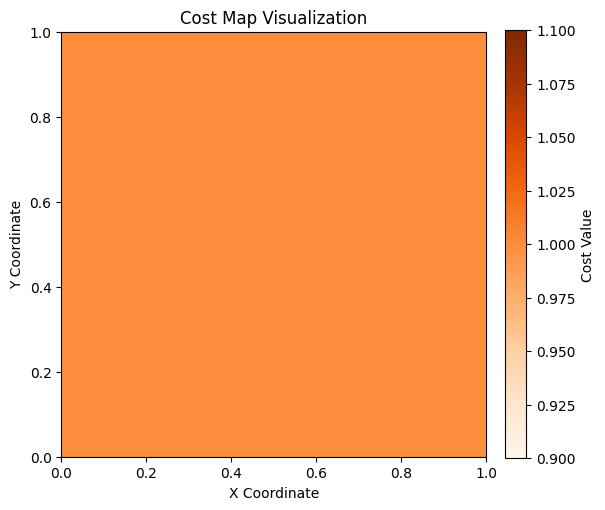

In [4]:
cost_map = create_cost_map(y_length=1, x_length=1, grain_size=0.01)
visualize_cost_map(cost_map, grain_size=0.01)

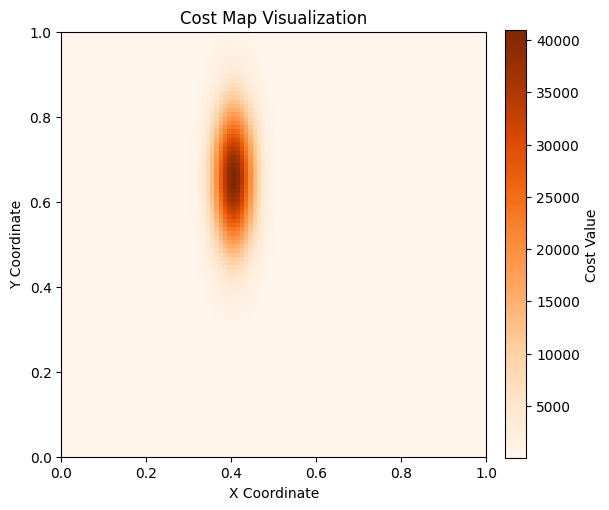

In [5]:
range_top = 1
range_bottom = 0.3
range_left = 0.3
range_right = 0.5

peak_cost = 1000

# Define a Gaussian distribution for the mountain range
x_mean = (range_left + range_right) / 2
y_mean = (range_bottom + range_top) / 2
x_std = (range_right - range_left) / 6  # Approx. 99.7% of values within bounds
y_std = (range_top - range_bottom) / 6

# Update the cost_map to reflect the mountain range
for i, row in cost_map.iterrows():
    x, y = row['x_coord'], row['y_coord']
    if range_left <= x <= range_right and range_bottom <= y <= range_top:
        # Calculate the cost based on a 2D Gaussian distribution
        cost_map.at[i, 'cost'] = int(
            peak_cost * norm.pdf(x, loc=x_mean, scale=x_std) * norm.pdf(y, loc=y_mean, scale=y_std)
        )

# Visualize the updated cost map
visualize_cost_map(cost_map, grain_size=0.01)